In [1]:
import findspark
findspark.init()
findspark.find()

'D:\\miniconda3\\lib\\site-packages\\pyspark'

In [2]:
import os

os.environ["JAVA_HOME"] = "C:Program Files\java\jdk1.8.0_331"

os.environ["HADOOP_HOME"] = "C:spark-2.3.2-bin-hadoop2.7"

In [3]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
.appName('app_name') \
.master('local[*]') \
.config('spark.sql.execution.arrow.pyspark.enabled', True) \
.config('spark.sql.session.timeZone', 'UTC') \
.config('spark.driver.memory','24G') \
.config('spark.ui.showConsoleProgress', True) \
.config('spark.sql.repl.eagerEval.enabled', True) \
.getOrCreate()

In [4]:
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import to_date, to_timestamp, date_format
from pyspark.sql import functions as sf
from functools import reduce
import pyspark.sql.functions as F
from pyspark.sql.functions import isnull, when, count, col, concat_ws, to_timestamp, lit, pandas_udf, PandasUDFType, current_date
from pyspark.sql.types import *
import folium
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

Importing plotly failed. Interactive plots will not work.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = spark.read.csv('northeast.csv', inferSchema=True, header=True, nanValue=-9999.0, nullValue=-9999)

In [7]:
df = df.drop("index", "station_code")

In [8]:
oldColumns = df.columns
newColumns = ['Date', 'Time', 'PCP', 'AP', 'MaxAP', 'MinAP', 'SR', 
              'T', 'DWPT', 'MaxT', 'MinT', 'MaxDWPT', 'MinDWPT', 
              'MaxTRH', 'MinTRH', 'RH', 'WD', 'WG', 'WS', 
              'Region', 'State', 'Station', 'Latitude', 'Longitude', 'Altitude']
df = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), df)

In [9]:
df = df.replace(float("NaN"), None)

In [10]:
df = df.withColumn("YM", date_format('Date', 'yyyy-MM'))

In [11]:
df = df.select('PCP', 'Station', 'YM')

In [12]:
df.show()

+----+--------+-------+
| PCP| Station|     YM|
+----+--------+-------+
|null|SALVADOR|2000-05|
|null|SALVADOR|2000-05|
|null|SALVADOR|2000-05|
|null|SALVADOR|2000-05|
|null|SALVADOR|2000-05|
|null|SALVADOR|2000-05|
|null|SALVADOR|2000-05|
|null|SALVADOR|2000-05|
|null|SALVADOR|2000-05|
|null|SALVADOR|2000-05|
|null|SALVADOR|2000-05|
|null|SALVADOR|2000-05|
|null|SALVADOR|2000-05|
|null|SALVADOR|2000-05|
|null|SALVADOR|2000-05|
|null|SALVADOR|2000-05|
|null|SALVADOR|2000-05|
|null|SALVADOR|2000-05|
|null|SALVADOR|2000-05|
|null|SALVADOR|2000-05|
+----+--------+-------+
only showing top 20 rows



In [13]:
df.printSchema()

root
 |-- PCP: double (nullable = true)
 |-- Station: string (nullable = true)
 |-- YM: string (nullable = true)



In [14]:
df = df.dropna().groupBy('YM', 'Station').sum('PCP').sort('YM')
df = df.withColumnRenamed("sum(PCP)","PCP")
df = df.withColumn("YM", F.trunc("YM", "month"))

In [15]:
df.show()

+----------+---------+------------------+
|        YM|  Station|               PCP|
+----------+---------+------------------+
|2000-10-01| SALVADOR|               5.0|
|2000-11-01| SALVADOR| 76.40000000000002|
|2000-12-01| SALVADOR| 90.80000000000001|
|2001-01-01| SALVADOR| 98.80000000000001|
|2001-02-01| SALVADOR|30.400000000000002|
|2001-03-01| SALVADOR| 263.5999999999999|
|2001-04-01| SALVADOR|109.80000000000005|
|2001-05-01| SALVADOR|207.99999999999994|
|2001-06-01| SALVADOR|             212.0|
|2001-07-01| SALVADOR|222.39999999999995|
|2001-08-01| SALVADOR|152.00000000000003|
|2001-09-01| SALVADOR|188.40000000000003|
|2001-10-01| SALVADOR|210.59999999999982|
|2001-11-01| SALVADOR|              45.6|
|2001-12-01| SALVADOR|114.40000000000002|
|2001-12-01|BARREIRAS|              23.2|
|2002-01-01| SALVADOR|219.39999999999992|
|2002-01-01|BARREIRAS|               0.0|
|2002-02-01| SALVADOR|104.80000000000003|
|2002-02-01|BARREIRAS|               0.0|
+----------+---------+------------

In [16]:
df.createOrReplaceTempView("weather")

In [17]:
sq = 'SELECT Station, YM as ds, sum(PCP) as y FROM weather GROUP BY Station, ds ORDER BY Station, ds'
station_weather = (spark.sql(sq).repartition(spark.sparkContext.defaultParallelism, ['Station'])).cache()

In [18]:
station_weather

Station,ds,y
CAMARATUBA,2008-05-01,142.00000000000003
CAMARATUBA,2008-06-01,190.59999999999974
CAMARATUBA,2008-07-01,192.1999999999998
CAMARATUBA,2008-08-01,238.5999999999997
CAMARATUBA,2008-09-01,72.60000000000007
CAMARATUBA,2008-10-01,44.400000000000006
CAMARATUBA,2008-11-01,13.799999999999997
CAMARATUBA,2008-12-01,17.599999999999994
CAMARATUBA,2009-01-01,148.8
CAMARATUBA,2009-02-01,310.0


In [19]:
result_schema = StructType([
    StructField('ds',DateType()),
    StructField('Station',StringType()),
    StructField('y',DoubleType()),
    StructField('yhat',DoubleType())
])

In [20]:
@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def forecast_climate(history):

    model = Prophet(interval_width=0.95,
        growth='linear',
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=True,
        seasonality_mode='multiplicative').add_seasonality(name='monthly', period=30.5, fourier_order=5)

    model.fit(history)

    future = model.make_future_dataframe(
        periods=12, 
        freq='M', 
        include_history=True
    )

    forecast = model.predict(future) 

    f_pd = forecast[['ds', 'yhat']].set_index('ds')

    st_pd = history[['ds', 'Station', 'y']].set_index('ds')

    results_pd = f_pd.join(st_pd, how='left')
    results_pd.reset_index(level=0, inplace=True)

    results_pd['Station'] = history['Station'].iloc[0]

    return results_pd[['ds', 'Station','y', 'yhat']]

In [21]:
forcast_results = (
    station_weather
    .groupBy('Station')
    .apply(forecast_climate)
)

D:\miniconda3\lib\site-packages\pyspark\sql\pandas\group_ops.py:81: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [22]:
forcast_results.show()

+----------+----------+------------------+------------------+
|        ds|   Station|                 y|              yhat|
+----------+----------+------------------+------------------+
|2008-05-01|CAMARATUBA|142.00000000000003| 219.1663862345166|
|2008-06-01|CAMARATUBA|190.59999999999974|275.68770613451755|
|2008-07-01|CAMARATUBA| 192.1999999999998|253.72627531697023|
|2008-08-01|CAMARATUBA| 238.5999999999997| 132.6145533611586|
|2008-09-01|CAMARATUBA| 72.60000000000007|109.31717522554223|
|2008-10-01|CAMARATUBA|44.400000000000006| 25.22506098212093|
|2008-11-01|CAMARATUBA|13.799999999999997| 26.34190540274985|
|2008-12-01|CAMARATUBA|17.599999999999994| 60.65491534237754|
|2009-01-01|CAMARATUBA|             148.8|  165.334991095759|
|2009-02-01|CAMARATUBA|             310.0|181.01106796906262|
|2009-03-01|CAMARATUBA|185.79999999999995|128.45551843216242|
|2009-04-01|CAMARATUBA|251.79999999999984|156.01646935761158|
|2009-05-01|CAMARATUBA|344.20000000000016|195.87291693016536|
|2009-06

In [23]:
import pandas as pd

In [24]:
weather_sub = forcast_results.tail(120)
weather_sub = pd.DataFrame(weather_sub, columns=['ds', 'Station', 'y', 'yhat'])
weather_sub = weather_sub.set_index('ds')

In [25]:
weather_sub['yhat'].describe()

count    120.000000
mean      58.851751
std       58.687560
min       -7.628644
25%       17.015534
50%       43.206830
75%       97.542370
max      282.020281
Name: yhat, dtype: float64

<AxesSubplot:xlabel='ds'>

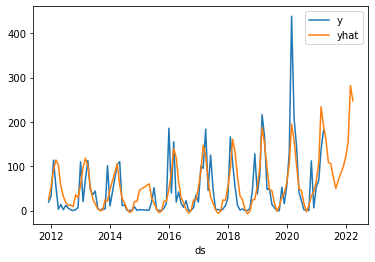

In [26]:
weather_sub[['y','yhat']].plot()

In [27]:
forcast_results.createOrReplaceTempView('new_forecasts')

In [28]:
import pandas as pd

# schema of expected result set
eval_schema = StructType([
    StructField('Station', StringType()),
    StructField('mae', FloatType()),
    StructField('mse', FloatType()),
    StructField('rmse', FloatType())
])

# define udf to calculate metrics
@pandas_udf(eval_schema, PandasUDFType.GROUPED_MAP)
def evaluate_forecast(data):
    data = data.dropna()
  
    # get station in incoming data set
    station = data['Station'].iloc[0]

    # calulate evaluation metrics
    mae = mean_absolute_error(data['y'], data['yhat'])
    mse = mean_squared_error(data['y'], data['yhat'])
    rmse = sqrt(mse)

    # assemble result set
    results = {'Station':[station], 'mae':[mae], 'mse':[mse], 'rmse':[rmse]}
    return pd.DataFrame.from_dict( results )

# calculate metrics
eval_results = (
  spark
    .table('new_forecasts')
    .select('Station', 'y', 'yhat')
    .groupBy('Station')
    .apply(evaluate_forecast)
)


D:\miniconda3\lib\site-packages\pyspark\sql\pandas\group_ops.py:81: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [29]:
eval_results.createOrReplaceTempView('new_forecast_evals')

In [30]:
sq = 'SELECT SUM(mae) as mae, SUM(mse) as mse, SUM(rmse) as rmse FROM new_forecast_evals'
spark.sql(sq).show()

+----------------+-----------------+------------------+
|             mae|              mse|              rmse|
+----------------+-----------------+------------------+
|5394.23396110872|487809.4639930725|7891.5469059993075|
+----------------+-----------------+------------------+



In [31]:
eval_df = eval_results.toPandas()

In [32]:
eval_df.to_csv('monthly_station_multiplicative_eval.csv')